# ThinkBrake: Threshold Sensitivity Experiment

In [1]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")

METRICS_FILE = Path("../metrics_summary.jsonl")
INCLUDE_MODELS = [
    "Qwen/Qwen3-4B-Thinking-2507",
    # "Qwen/Qwen3-4B",
    # "Qwen/Qwen3-14B",
    # "Qwen/Qwen3-32B"
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "microsoft/phi-4-reasoning",
]
CATEGORY = "gsm8k-val"
INCLUDE_THRESHOLDS = [0.05, 0.1, 0.25, 1.0, 2.5]

In [2]:
def load_metrics(file_path):
    if not file_path.exists():
        print(f"Warning: {file_path} not found.")
        return []
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                data.append(json.loads(line))
    return data


all_metrics = load_metrics(METRICS_FILE)
print(f"Total records loaded: {len(all_metrics)}")

Total records loaded: 1000


In [3]:
def process_model_data(model_name, benchmark, all_metrics):

    model_metrics = [
        r
        for r in all_metrics
        if (
            r.get("model") == model_name
            or r.get("model") == model_name.replace("/", "_")
        )
        and r.get("benchmark") == benchmark
    ]

    baseline_entry = next(
        (r for r in model_metrics if r.get("method") == "rollout"), None
    )

    plot_data = []
    for r in model_metrics:
        if r.get("method") == "thinkbrake":
            try:
                t_val = float(r.get("threshold"))
                if not any(abs(t_val - t) < 1e-6 for t in INCLUDE_THRESHOLDS):
                    continue

                token_reduction = None
                if baseline_entry:
                    base_tokens = baseline_entry.get("avg_token_length", 0)
                    curr_tokens = r.get("avg_token_length", 0)
                    if base_tokens > 0:
                        token_reduction = (
                            (base_tokens - curr_tokens) / base_tokens * 100
                        )

                entry = {
                    "threshold": t_val,
                    "accuracy": r.get("accuracy", 0),
                    "majority_accuracy": r.get("majority_accuracy"),
                    "avg_token_length": r.get("avg_token_length", 0),
                    "token_reduction": token_reduction,
                    "type": "ThinkBrake",
                }
                plot_data.append(entry)
            except (ValueError, TypeError):
                continue

    df = pd.DataFrame(plot_data)
    if not df.empty:
        df = df.sort_values("threshold")

    return df, baseline_entry


processed_data = {}
for model in INCLUDE_MODELS:
    df, baseline = process_model_data(model, CATEGORY, all_metrics)
    if not df.empty or baseline:
        processed_data[model] = {"df": df, "baseline": baseline}
        print(
            f"Processed {model}: {len(df)} ThinkBrake points, Baseline found: {baseline is not None}"
        )
    else:
        print(f"No data found for {model}")

Processed Qwen/Qwen3-4B-Thinking-2507: 5 ThinkBrake points, Baseline found: True
Processed deepseek-ai/DeepSeek-R1-Distill-Qwen-7B: 5 ThinkBrake points, Baseline found: True
Processed microsoft/phi-4-reasoning: 5 ThinkBrake points, Baseline found: True


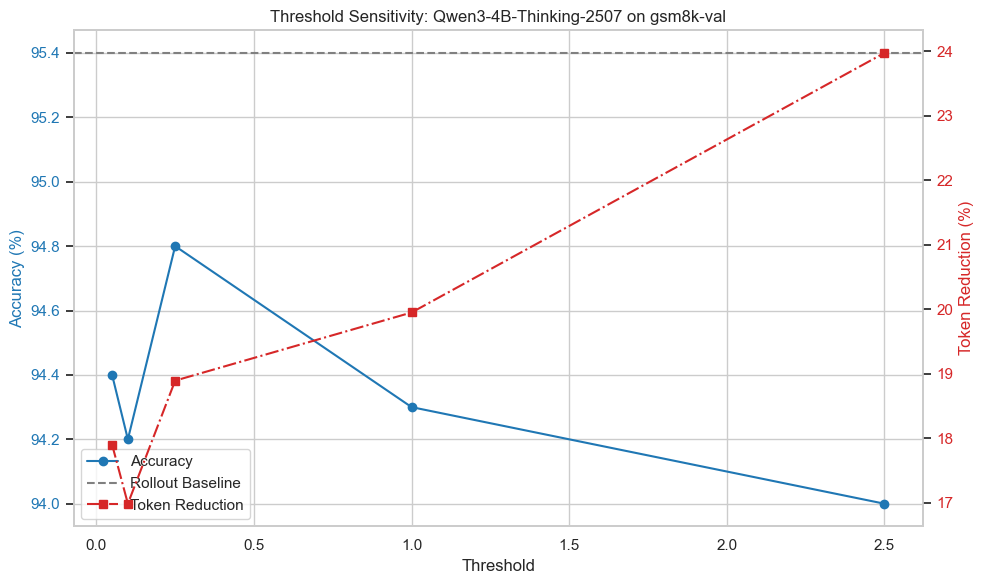

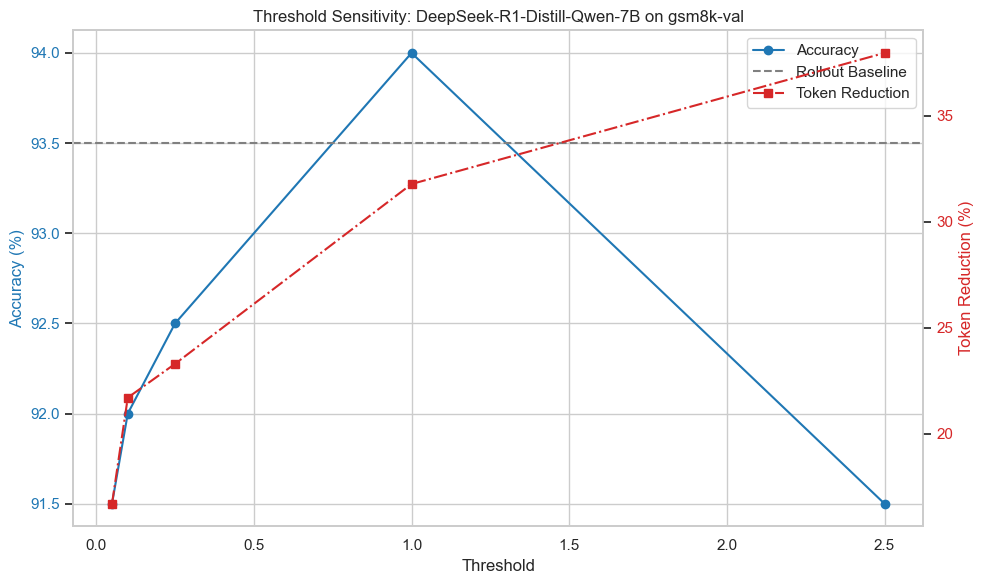

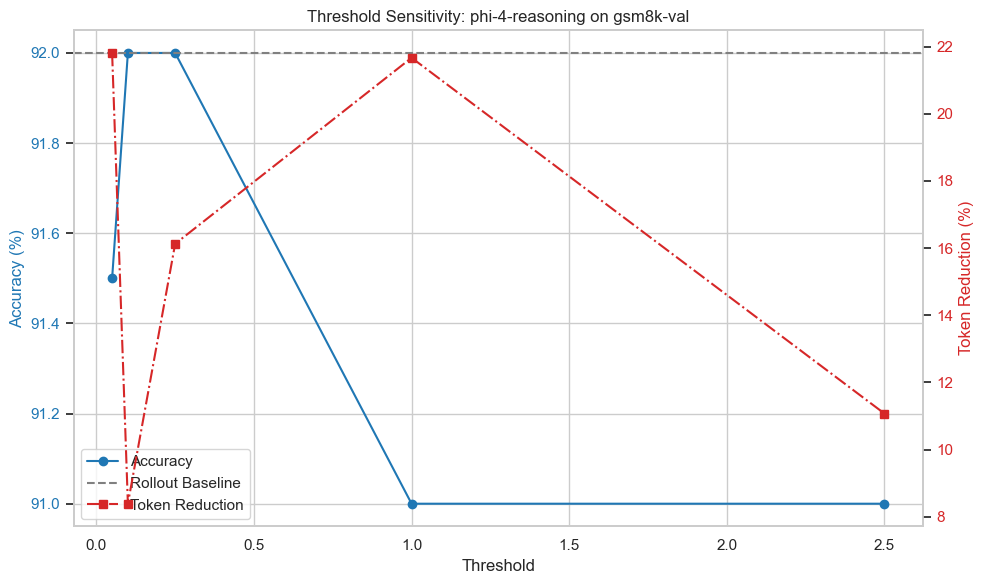

In [ ]:
for model, data in processed_data.items():
    df = data["df"]
    baseline_entry = data["baseline"]

    if df.empty and not baseline_entry:
        continue

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Accuracy
    color = "tab:blue"
    ax1.set_xlabel("Threshold")
    ax1.set_ylabel("Accuracy (%)", color=color)

    lines = []
    if not df.empty:
        (l1,) = ax1.plot(
            df["threshold"], df["accuracy"], marker="o", color=color, label="Accuracy"
        )
        lines.append(l1)

    ax1.tick_params(axis="y", labelcolor=color)
    ax1.grid(True)

    # Plot Baseline
    if baseline_entry:
        base_acc = baseline_entry.get("accuracy", 0)
        l_base = ax1.axhline(
            y=base_acc, color="gray", linestyle="--", label="Rollout Baseline"
        )
        lines.append(l_base)

    # Plot Token Reduction
    if (
        not df.empty
        and "token_reduction" in df.columns
        and df["token_reduction"].notna().any()
    ):
        ax2 = ax1.twinx()
        color = "tab:red"
        ax2.set_ylabel("Token Reduction (%)", color=color)
        (l2,) = ax2.plot(
            df["threshold"],
            df["token_reduction"],
            marker="s",
            color=color,
            linestyle="-.",
            label="Token Reduction",
        )
        lines.append(l2)
        ax2.tick_params(axis="y", labelcolor=color)
        ax2.grid(False)

    # Legend
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc="best")

    display_name = model.split("/")[-1]
    plt.title(f"Threshold Sensitivity: {display_name} on {CATEGORY}")
    plt.tight_layout()
    plt.show()